# Overview
The goal of this competition is to predict overall writing quality. Does typing behavior affect the outcome of an essay? You will develop a model trained on a large dataset of keystroke logs that have captured writing process features.



## Introduction
This notebook addresses the Kaggle competition "Linking Writing Processes to Writing Quality," where the goal is to predict essay quality based on typing behavior. In this analysis, we explore the provided dataset, perform feature engineering, build predictive models, and visualize the results.

# Data Exploration and Preprocessing
Let us start by exploring the training data, visualizing essay quality distribution, and identifying key patterns in typing behavior.
**Also don't forget to import our loved ones** ;)) 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

print('Import sucessful, for libraries')

# Load the training and test data
train_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
test_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')
train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')

# Check data structure and initial summary
print(train_logs.head())
print(train_logs.info())

Import sucessful, for libraries
         id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 11 columns):
 #   Column   

# Data Visualization
Let's take a initial look on our data to undertand the structure

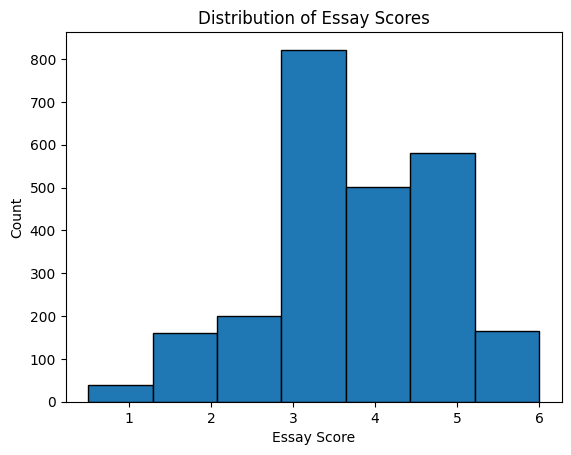

In [2]:
# Create a histogram of essay scores
plt.hist(train_scores['score'], bins=7, edgecolor='k')
plt.xlabel('Essay Score')
plt.ylabel('Count')
plt.title('Distribution of Essay Scores')
plt.show()

In [3]:
train_logs['text_change'].unique()

array(['NoChange', 'q', ' ', ..., 'qq qqq qqqq qqqqq',
       'qq qqqqq qqqq qq qqqqq ',
       '\n qqqqq qqqqqq qqqqqqqqqq qq q qqqqqqqq qqq qqq qqqq qqqqqq q qqq. \n\nqqqq qqq qq qqqqqqq qqq:\n- \n- qqq qqqqqqq qqqq q qqqqqq qqqqqqqq qq qqqq qqqqqqqq '],
      dtype=object)

In [4]:
print(train_logs.groupby("id")['event_id'].size())
print(train_logs.groupby("id")['cursor_position'].max())

id
001519c8    2557
0022f953    2454
0042269b    4136
0059420b    1556
0075873a    2531
            ... 
ffb8c745    4739
ffbef7e5    2604
ffccd6fd    3063
ffec5b38    3242
fff05981    3619
Name: event_id, Length: 2471, dtype: int64
id
001519c8    1539
0022f953    1676
0042269b    2291
0059420b    1047
0075873a    1402
            ... 
ffb8c745    1634
ffbef7e5    1877
ffccd6fd    2761
ffec5b38    2133
fff05981    1496
Name: cursor_position, Length: 2471, dtype: int64


# Feature Engineering

Let's extract relevant features from the typing behavior data, such as pause frequency and revision counts, etc. These features are used to train our machine learning models.

In [5]:
#print(merged_data['activity'].value_counts().head(10))

In [6]:
#merged_data['text_change'].value_counts().head(50)

In [7]:
#train_logs.isnull().sum()

In [8]:
test_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [9]:
def feat_eng(train_logs):
    grouped_data = train_logs.groupby('id')

    grouped_data = grouped_data.agg({
        'event_id': 'count',
        'action_time': 'sum',
        'cursor_position': 'max',
        'word_count': 'max'
    })

    # Get the top 10 most frequent 'activity' values
    top_activity_values = train_logs['activity'].value_counts().nlargest(10).index

    # Get the top 50 most frequent 'text_change' values
    top_text_change_values = train_logs['text_change'].value_counts().nlargest(30).index

    # Filter 'activity' and 'text_change' columns based on the top values
    filtered_merged_data = train_logs[train_logs['activity'].isin(top_activity_values)]
    filtered_merged_data = filtered_merged_data[filtered_merged_data['text_change'].isin(top_text_change_values)]

    # Group by 'id' and transform to get the count for each 'activity' and 'text_change' value
    activity_counts = filtered_merged_data.groupby('id')['activity'].value_counts().unstack(fill_value=0)
    text_change_counts = filtered_merged_data.groupby('id')['text_change'].value_counts().unstack(fill_value=0)

    # Concatenate the count columns to the grouped_data DataFrame
    grouped_data = pd.concat([grouped_data, activity_counts, text_change_counts], axis=1)
    
    return grouped_data

In [10]:
train_df = feat_eng(train_logs)
train_df = train_df.merge(train_scores, on='id')
train_df = train_df.drop(columns=['id'])
train_df

,event_id,action_time,cursor_position,word_count,Input,"Move From [624, 625] To [845, 846]",Nonproduction,Paste,Remove/Cut,Replace,...,q,q => q,qq => q,qqq => q,qqq => q,qqqq => q,qqqq => q,qqqqq => q,qqqqqq => q,score
0,2557,297243,1539,256,2010,0,120,0,417,1,...,1939,0,0,0,0,1,0,0,0,3.5
1,2454,275391,1676,323,1938,0,254,0,260,1,...,1698,0,0,0,0,0,0,0,1,3.5
2,4136,421201,2291,404,3515,0,175,0,436,0,...,3257,0,0,0,0,0,0,0,0,6.0
3,1556,189596,1047,206,1304,0,99,0,151,0,...,1146,0,0,0,0,0,0,0,0,2.0
4,2531,313702,1402,252,1942,0,72,0,517,0,...,1964,0,0,0,0,0,0,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,4739,499670,1634,461,3588,0,189,0,959,1,...,3605,0,0,0,0,0,1,0,0,3.5
2467,2604,214221,1877,438,2395,0,148,0,60,1,...,1920,1,0,0,0,0,0,0,0,4.0
2468,3063,231580,2761,201,2849,0,126,0,88,0,...,1031,0,0,0,0,0,0,0,0,1.5
2469,3242,289439,2133,413,2895,0,71,0,274,0,...,2593,0,0,0,0,0,0,0,0,5.0


# Model Building
Let's train and evaluate our model.

In [11]:

X = train_df.drop(columns='score')
y = train_df['score']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a model (e.g., Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the validation set
predictions = model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.4631880158418753


# Visualization of Model Results
Visualizing the results of our model, such as a scatter plot comparing actual scores to predicted scores.

In [12]:
len(predictions)

495

In [13]:
test_df = feat_eng(test_logs)
test_df

,event_id,action_time,cursor_position,word_count,Input,,q
id,,,,,,,
0000aaaa,2,172,1,0,2,2,0
2222bbbb,2,113,1,1,2,0,2
4444cccc,2,150,1,1,2,1,1


In [14]:
train_columns = X.columns
for col in train_columns:
    if col not in test_df.columns:
        test_df[col] = 0

      

#test_df = test_df.drop(columns=['id'], axis=1)

In [15]:
test_df = test_df.fillna(0)
test_df = test_df[X.columns] 

# Preparing Submissions


In [16]:
test_predictions = model.predict(test_df)
# Create a submission DataFrame
submission = pd.DataFrame({'id': test_logs['id'].unique(), 'score': test_predictions})
# I don't know how I missed, remove the dups here
submission = submission.drop_duplicates(subset=['id'])

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

print('Sucessfully submited')


Sucessfully submited
